In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import pyvo as vo
import pickle
from astroquery.vizier import Vizier
import concurrent.futures
import requests
import os
from tqdm import tqdm
import concurrent.futures
import requests
import time
from tqdm import tqdm
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry


In [2]:
# Function to download a file with retries
def download_file(url):
    file_name = os.path.join(save_folder, url.split('/')[-1])
    
    # If the file already exists, return success
    if os.path.exists(file_name):
        return True, file_name
    
    # Retry mechanism
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[429, 500, 502, 503, 504])
    session = requests.Session()
    session.mount('https://', HTTPAdapter(max_retries=retries))

    try:
        response = session.get(url)
        response.raise_for_status()  # Check for HTTP errors
        
        # Save the file content
        with open(file_name, 'wb') as f:
            f.write(response.content)
        
        return True, file_name  # Success
    except requests.HTTPError as e:
        return False, f"Failed to download {url}: {e}"  # Failure
    except Exception as e:
        return False, f"Other error occurred: {e}"

# Main function to download all files
def download_all_files(urls):
    success_count = 0
    failure_count = 0

    # Reduce the number of threads to avoid overwhelming the network
    with concurrent.futures.ThreadPoolExecutor(max_workers=300) as executor:
        # Create a progress bar with the total number of URLs
        with tqdm(total=len(urls), desc="Downloading", unit="file") as pbar:
            futures = {executor.submit(download_file, url): url for url in urls}
            
            for future in concurrent.futures.as_completed(futures):
                success, result = future.result()
                pbar.update(1)  # Update the progress bar for each completed download
                
                if success:
                    success_count += 1
                else:
                    failure_count += 1
                    #print(f"Error: {result}")

    # Print final counts for successful and failed downloads
    print(f"\nDownload complete! Successfully downloaded: {success_count}, Failed: {failure_count}")

In [3]:
# Load your STAR data and LAMOST catalog (assuming you have a local CSV or FITS file for LAMOST)
star_data = pd.read_pickle("star_data.pkl")  # Loaded STAR data
lamost_catalog = pd.read_csv("dr9_v2.0_LRS_catalogue.csv")  # Assuming CSV format for LAMOST catalog

# Ensure that RA and Dec columns are numeric and have units
star_data['ra'] = pd.to_numeric(star_data['ra'], errors='coerce')  # Coerce non-numeric to NaN
star_data['dec'] = pd.to_numeric(star_data['dec'], errors='coerce')
lamost_catalog['ra'] = pd.to_numeric(lamost_catalog['ra'], errors='coerce')
lamost_catalog['dec'] = pd.to_numeric(lamost_catalog['dec'], errors='coerce')

# Drop rows with NaN values in RA or Dec
star_data = star_data.dropna(subset=['ra', 'dec'])
lamost_catalog = lamost_catalog.dropna(subset=['ra', 'dec'])

# Convert STAR and LAMOST data to SkyCoord objects for crossmatching
star_coords = SkyCoord(ra=star_data['ra'].values*u.deg, dec=star_data['dec'].values*u.deg)
lamost_coords = SkyCoord(ra=lamost_catalog['ra'].values*u.deg, dec=lamost_catalog['dec'].values*u.deg)

# Perform the crossmatch using astropy's match_to_catalog_sky function
idx, d2d, _ = star_coords.match_to_catalog_sky(lamost_coords)

# Define a matching radius
match_radius = 1 * u.arcsec
matches = d2d < match_radius

# Filter the matches
matched_star = star_data.iloc[matches]
matched_lamost = lamost_catalog.iloc[idx[matches]]

# Combine matched data
star_lamost_data = pd.concat([matched_star.reset_index(drop=True), matched_lamost.reset_index(drop=True)], axis=1)

# Save the crossmatched data
star_lamost_data.to_pickle("star_lamost_data.pkl")

print(f"Number of matches: {star_lamost_data.shape[0]}")
print("out of ", star_data.shape[0])
del star_data, lamost_catalog

Number of matches: 384629
out of  3845419


In [ ]:
# Load the crossmatched data
star_lamost_data = pd.read_pickle("star_lamost_data.pkl")
obsid_list = star_lamost_data['obsid'].values

# Specify the folder to save the files
save_folder = "star_spectra"

# Create the folder if it doesn't exist
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# List of URLs to download (assuming obsid_list is available)
urls = [f"https://www.lamost.org/dr7/v2.0/spectrum/fits/{obsid}" for obsid in obsid_list]

# Call the function to start downloading
download_all_files(urls)

# Free up memory by deleting the large DataFrame
del star_lamost_data

Downloading:  53%|█████▎    | 204017/384629 [5:09:18<591:00:55, 11.78s/file] 

# Prep Gaia Lamost Data Fusion

In [3]:
# star directory
directory = 'star_spectra1/'

# Get a list of all files in the directory
id_train_star = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

# Print the number of files
print('Number of STAR spectra:', len(id_train_star))

Number of STAR spectra: 350660


In [4]:
lamost_catalog = pd.read_csv("dr9_v2.0_LRS_catalogue.csv")  # Assuming CSV format for LAMOST catalog

In [6]:
# Time how long it takes for the crossmatch
start_time = time.time()

obsid_list = id_train_star
obsid_list = [int(obsid) for obsid in obsid_list]

# Filter the DataFrame
filtered_df = lamost_catalog[lamost_catalog['obsid'].isin(obsid_list)]

# Get the 'ra' and 'dec' values
ra_dec_values = filtered_df[['ra', 'dec']]
print(ra_dec_values)    

# Load your GAL data and LAMOST catalog (assuming you have a local CSV or FITS file for LAMOST)
star_data = pd.read_pickle("star_data.pkl")  # Loaded STAR data

# Ensure that RA and Dec columns are numeric and have units
star_data['ra'] = pd.to_numeric(star_data['ra'], errors='coerce')  # Coerce non-numeric to NaN
star_data['dec'] = pd.to_numeric(star_data['dec'], errors='coerce')

# Drop rows with NaN values in 'ra' and 'dec' columns
star_data = star_data.dropna(subset=['ra', 'dec'])
ra_dec_values = filtered_df[['obsid','ra', 'dec']]

# Convert GAL and LAMOST data to SkyCoord objects for crossmatching
star_coords = SkyCoord(ra=star_data['ra'].values*u.deg, dec=star_data['dec'].values*u.deg)
lamost_coords = SkyCoord(ra=ra_dec_values['ra'].values*u.deg, dec=ra_dec_values['dec'].values*u.deg)

# Crossmatch the GAL and LAMOST data
idx, d2d, _ = star_coords.match_to_catalog_sky(lamost_coords)

# Define a matching radius
match_radius = 1 * u.arcsec
matches = d2d < match_radius

# Filter the matches
matched_star = star_data.iloc[matches]
matched_lamost = ra_dec_values.iloc[idx[matches]]

# Combine the matched data
matched_data = pd.concat([matched_star.reset_index(drop=True), matched_lamost.reset_index(drop=True)], axis=1)

######################################################################################################################
# Print time taken for crossmatch
print("--- %s seconds ---" % (time.time() - start_time))

                  ra        dec
37        331.730088  -1.296553
50        331.885679  -1.197079
307       331.128933  -1.271316
377       330.907342   0.679787
387       331.063552   0.892625
...              ...        ...
10686265  226.695933  26.850690
10686488  278.230130   8.332171
10686557  278.371090  12.332223
10686604  278.977130  11.613377
10686685  279.217760  10.592424

[350660 rows x 2 columns]
--- 13.388880968093872 seconds ---


In [7]:
print(f"Number of matches: {matched_data.shape[0]}")

Number of matches: 351312


In [8]:
star_data = matched_data[['obsid','ra', 'dec','ra_error', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error']]
star_data.columns = ['obsid','ra','ra2', 'dec', 'dec2','ra_error', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error']
star_data = star_data.drop(columns=['ra2', 'dec2'])
print(star_data.columns)

# create a new folder for the pickles
if not os.path.exists("Pickles/allstars"):
    os.makedirs("Pickles/allstars")
star_data.to_pickle("Pickles/allstars/star_gaia.pkl")

Index(['obsid', 'ra', 'dec', 'ra_error', 'dec_error', 'parallax',
       'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
       'phot_rp_mean_flux_error'],
      dtype='object')


# Dealing with nans

In [9]:
# Printing the number of nans in each column
print(star_data.isnull().sum())

obsid                         0
ra                            0
dec                           0
ra_error                      0
dec_error                     0
parallax                   1817
parallax_error             1817
pmra                       1817
pmra_error                 1817
pmdec                      1817
pmdec_error                1817
phot_g_mean_flux              7
phot_g_mean_flux_error        7
phot_bp_mean_flux           575
phot_bp_mean_flux_error     575
phot_rp_mean_flux           575
phot_rp_mean_flux_error     575
dtype: int64


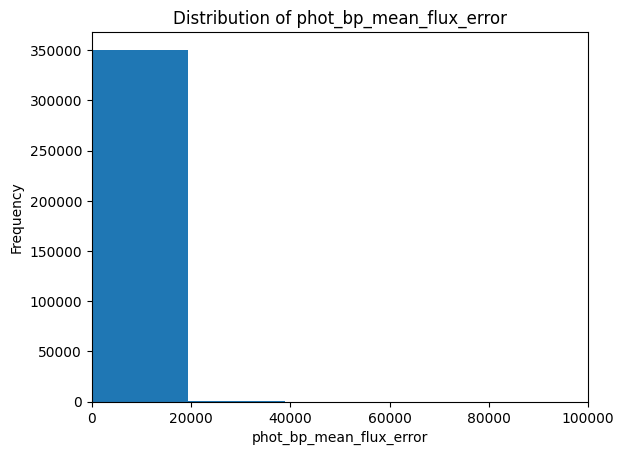

In [20]:
# plot the distribution of bp mean flux error
plt.hist(star_data['phot_bp_mean_flux_error'], bins=100)
plt.xlabel('phot_bp_mean_flux_error')
plt.ylabel('Frequency')
plt.title('Distribution of phot_bp_mean_flux_error')
plt.xlim(0, 1e5)
plt.show()


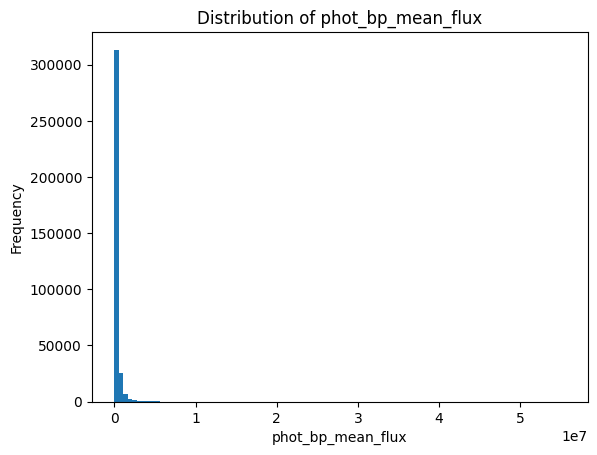

In [22]:
# plot the distribution of bp mean flux
plt.hist(star_data['phot_bp_mean_flux'], bins=100)
plt.xlabel('phot_bp_mean_flux')
plt.ylabel('Frequency')
plt.title('Distribution of phot_bp_mean_flux')
plt.show()


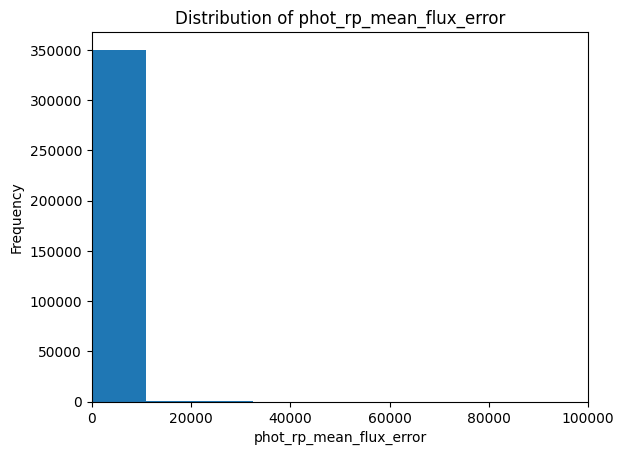

In [24]:
# plot the distribution of rp mean flux error
plt.hist(star_data['phot_rp_mean_flux_error'], bins=100)
plt.xlabel('phot_rp_mean_flux_error')
plt.ylabel('Frequency')
plt.title('Distribution of phot_rp_mean_flux_error')
plt.xlim(0, 1e5)
plt.show()


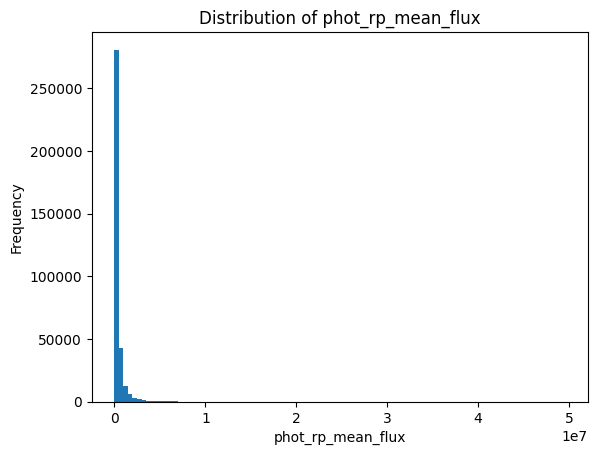

In [27]:
# plot the distribution of rp mean flux
plt.hist(star_data['phot_rp_mean_flux'], bins=100)
plt.xlabel('phot_rp_mean_flux')
plt.ylabel('Frequency')
plt.title('Distribution of phot_rp_mean_flux')
plt.show()

In [29]:
def clean_nans(input_pkl, output_pkl):    
    # open the pickles
    df = pd.read_pickle(input_pkl)

    # add a flag column if parallax is nan
    df['flagnopllx'] = np.where(df['parallax'].isnull(), 1, 0)

    # if parallax is nan, set the parallax to 0 and the error to 10
    # 10 is a large value but still normalizabe

    df.fillna({'parallax':0}, inplace=True)
    df.fillna({'parallax_error':10}, inplace=True)

    # if pmra or pmdec is nan, set the pmra to 0 and the error to 10

    df.fillna({'pmra':0}, inplace=True)
    df.fillna({'pmra_error':10}, inplace=True)
    df.fillna({'pmdec':0}, inplace=True)
    df.fillna({'pmdec_error':10}, inplace=True)

    # add a flag column if  phot_bp_mean_flux, phot_rp_mean_flux is nan
    df['flagnoflux'] = np.where(df['phot_bp_mean_flux'].isnull(), 1, 0)

    # if phot_bp_mean_flux, phot_rp_mean_flux is nan, set the flux to 0 and the error to 10
    df.fillna({'phot_bp_mean_flux':0}, inplace=True)
    df.fillna({'phot_bp_mean_flux_error':50000}, inplace=True) # 50000 is a large value but still normalizabe
    df.fillna({'phot_rp_mean_flux':0}, inplace=True)
    df.fillna({'phot_rp_mean_flux_error':50000}, inplace=True)

    # print the number of nans in each column
    print(df.isnull().sum())

    # if any nans are left, drop the row, save the obsid of dropped row,print the number of rows dropped out of the total
    na_free = df.dropna()
    only_na = df[~df.index.isin(na_free.index)]    
    print('Number of rows now:', len(na_free))
    print('Number of rows dropped:', len(df) - len(na_free), 'accounting for', ((len(df)-len(na_free))/len(df))*100, '%')

    # save the pickle
    df.to_pickle(output_pkl)
    return only_na['obsid']

obsid_drop_star = clean_nans("Pickles/allstars/star_gaia.pkl", "Pickles/allstars/star_dropna1.pkl")

obsid                      0
ra                         0
dec                        0
ra_error                   0
dec_error                  0
parallax                   0
parallax_error             0
pmra                       0
pmra_error                 0
pmdec                      0
pmdec_error                0
phot_g_mean_flux           7
phot_g_mean_flux_error     7
phot_bp_mean_flux          0
phot_bp_mean_flux_error    0
phot_rp_mean_flux          0
phot_rp_mean_flux_error    0
flagnopllx                 0
flagnoflux                 0
dtype: int64
Number of rows now: 351305
Number of rows dropped: 7 accounting for 0.001992530855763538 %


# Converting fits to nparray

In [31]:
# Batch size: how many files to process before writing to the CSV
BATCH_SIZE = 10000

# Output CSV file path
output_file = 'Pickles/train_lamost_data.csv'

# Create the CSV file with headers before appending data
with open(output_file, 'w') as f:
    # Create an empty DataFrame just for headers
    columns = [f'col_{i}' for i in range(5000)] + ['file_name', 'label', 'row']
    pd.DataFrame(columns=columns).to_csv(f, index=False)

# Total number of files for the progress bar
total_files = sum([len(files) for r, d, files in os.walk('lamost_train_set/')])

# Initialize the tqdm progress bar
with tqdm(total=total_files, desc='Processing FITS files') as pbar:

    folder_path = "star_spectra1/"
    
    # Prepare a list for batch processing
    batch_list = []
    
    # Loop through each FITS file in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Open the FITS file and extract the relevant data
        with fits.open(file_path) as hdul:
            # Extract the first 3 rows and first 3748 columns
            data = hdul[0].data[:3, :3748]  # This gets the first 3 rows
            
            # Loop through the 3 rows and append them to the batch list
            for i, row_data in enumerate(data):
                # Create a dictionary with the data, label, and file name
                data_dict = {f'col_{j}': value for j, value in enumerate(row_data)}
                data_dict['file_name'] = filename  # Include file name
                data_dict['label'] = "star"         # Include label
                data_dict['row'] = i               # Track which row from the FITS file
                
                # Append the dictionary to the batch list
                batch_list.append(data_dict)
        
        # Increment the progress bar
        pbar.update(1)

        # Write the batch to CSV if batch size is met
        if len(batch_list) >= BATCH_SIZE:
            df = pd.DataFrame(batch_list)
            df.to_csv(output_file, mode='a', header=False, index=False)
            batch_list.clear()  # Clear the batch list after writing

    # Write any remaining data in the batch at the end of the folder loop
    if batch_list:
        df = pd.DataFrame(batch_list)
        df.to_csv(output_file, mode='a', header=False, index=False)
        batch_list.clear()  # Clear the list after writing



Processing FITS files: 0it [00:00, ?it/s]


NameError: name 'fits' is not defined